In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random

In [2]:
def SVD():
    global A
    lu, U = np.linalg.eig(np.matmul(A, A.T))
    l = np.sqrt([x.real for x in lu if (x>0 and x.real == x and x>1e-15)])
    U=U.real
#     S = np.zeros((len(l), len(l)))
#     for i in range(len(l)):
#         S[i][i] = l[i]
#     Sinv = np.linalg.inv(S)

#     S2 = np.zeros((len(A[:]), len(A[0,:])))
#     S2[:len(S), :len(S)] = S
#     S=S2

#     S2 = np.zeros((len(A[0,:]), len(A[:])))
#     S2[:len(Sinv), :len(Sinv)] = Sinv
#     Sinv=S2

#     V = np.matmul(np.matmul(Sinv, U.T), A).T

#     S = np.zeros((len(A[:]), len(A[0,:])))
#     for i in range(len(l)):
#         S[i][i] = l[i]
    
    beta = len(A)/len(A[0,:])
    om = 0.56*beta*beta*beta - 0.95*beta*beta + 1.82*beta + 1.43
    tau = om*l[int(np.floor(len(l)/2))]
    l = [x for x in l if x > tau]
    return(U, l)

In [3]:
def compare(x):
    global mean
    global A
    global U2
    global numbers
    global X2
    
    k = 10
    closest = np.full((2,k), float('inf'))
    
    X = np.matmul(U2, x[...,None]-mean)
    mindist = float('inf')
    for i in range(len(A[0])):
        Y = X2[:,i][...,None]
        dist = np.linalg.norm(X-Y)
        if dist < closest[0][k-1]:
            closest[0][k-1] = dist
            closest[1][k-1] = numbers.label[i]
            closest = closest[:,np.argsort(closest)[0]]

    return(np.argmax(np.bincount(closest[1].astype(int))))

In [4]:
numbers = pd.read_csv('train.csv')

In [5]:
S = np.array(numbers)[:10000, 1:].T
mean = np.mean(S, axis=1)
mean = mean[...,None]
A = S - mean
U, l = SVD()
U2 = U[:, :len(l)].T
X2 = np.matmul(U2, A)

In [6]:
numbers2 = pd.read_csv('test.csv')

3

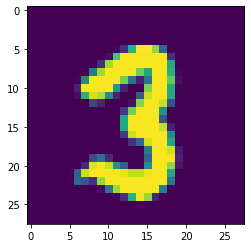

In [7]:
num = random.randint(len(numbers2))
test = np.array(numbers2.iloc[num])
fig, ax = plt.subplots()
ax.imshow(np.array(numbers2.iloc[num]).reshape((28, 28)))
compare(test)

In [8]:
count = 0
number = 1000

for i in range(number):
    num = random.randint(10000)
    test = np.array(numbers)[-num, 1:]
    b = int(numbers.label[len(numbers)-num])
    if compare(test) == int(numbers.label[len(numbers)-num]):
        count += 1
    if not i%10:
        print(number-i)

print(count/number)

100
90
80
70
60
50
40
30
20
10
0.96


In [9]:
from math import exp
from random import random

def activation(num):
#     res = 1/(1+np.exp(-num))
    
    res = np.arctan(num)
    
#     num[num<0] = 0
#     res = num
    
    return(res)

def deriv(num):
#     res = num*(1-num)
    
    res = 1/((num*num)+1)
    
#     num[num<0] = 0
#     num[num>0] = 1
#     res = num
    
    return(res)
    
def forward(x, h, w, y, b, num_cols,T):
    for i in range(num_cols):
        if i == 0:
            h[i][:, 0] = np.matmul(x, w[i]) + b[i].T
        else:
            h[i][:, 0] = np.matmul(h[i-1][:, 1], w[i]) + b[i].T
        h[i][:, 1] = activation(h[i][:,0])
    
    y[:, 0] = np.matmul(h[num_cols-1][:,1], w[num_cols])
    y[:, 1] = activation(y[:,0])
    y[:, 2] = (y[:, 1] - T)*deriv(y[:, 1])
    #print(((y[:, 1] - T)**2).mean())
    return(h, y)

def learn(x, h, w, y, b, num_cols, T, eta):
    
    h, y = forward(x, h, w, y, b, num_cols, T)

    #Backwards
    for i in reversed(range(num_cols+1)):
        if i == num_cols:
            w[i] = w[i] - eta*np.matmul(h[i-1][:,1][...,None], y[:,2][None,...])
            h[i-1][:,2] = np.matmul(y[:,2], w[i].T)*deriv(h[i-1][:,1])
        else:
            if i != 0:
                w[i] = w[i] - eta*np.matmul(h[i-1][:,1][...,None], h[i][:,2][None,...])
                h[i-1][:,2] = np.matmul(h[i][:,2], w[i].T)*deriv(h[i-1][:,1])
            else:
                w[i] = w[i] - eta*np.matmul(np.array(x)[...,None], h[i][:,2][None,...])
            b[i] = b[i] - 0.1*h[i][:, 2]
    
    return(h, w, b)

def setup(num_cols, num_rows, num_ans):
    h = []
    w = []
    b = []
    y = np.zeros((num_ans,3))
    
    for i in range(num_cols):
        h.append(np.zeros((num_rows,3)))
        w.append(np.random.rand(num_rows,num_rows))
        b.append(np.random.rand(num_rows))

    w.append(np.random.rand(num_rows,num_ans))
    
    return(h, w, b, y)


In [10]:
dataset = X2.T
#dataset = np.array(numbers)[:10000, 1:]
target = np.array(numbers.label)

num_ans = len(set(target))
num_cols = 5
num_rows = len(dataset)
eta = 0.00008
# 2 rows - 0.00008
# eta = 0.8

h, w, b, y = setup(num_cols, len(dataset[0]), num_ans)

for i in range(num_rows):
    T = [0]*num_ans
    T[target[i]] = 1
    h, w, b = learn(dataset[i], h, w, y, b, num_cols, T, eta)

In [11]:
count = 0
test = np.array(numbers)[-4000:, 1:]
test = np.matmul(U2, test.T-mean).T
testtarg = np.array(numbers.label)[-4000:]
for i in range(len(test)):
    z, y3 = forward(test[i], h, w, y, b, num_cols, T)
    #print(list(y3[:,0]).index(max(list(y3[:,0]))), target[i])
    if list(y3[:,0]).index(max(list(y3[:,0]))) == testtarg[i]:
        count += 1

print(count/len(test))

0.10025


In [15]:
def findeta(dataset, target, test, testtarg, aim):
    
    power = 1
    num_ans = len(set(target))
    num_cols = 3
    num_rows = len(dataset)
    global best 
    best = 0
    global besteta 
    besteta = 0
    
    for j in range(10**3-1):
        h, w, b, y = setup(num_cols, len(dataset[0]), num_ans)

        eta = (j)/(10**5)

        for i in range(num_rows):
            T = [0]*num_ans
            T[target[i]] = 1
            h, w, b = learn(dataset[i], h, w, y, b, num_cols, T, eta)

        count = 0
        for i in range(len(test)):
            z, y3 = forward(test[i], h, w, y, b, num_cols, T)
            if list(y3[:,0]).index(max(list(y3[:,0]))) == testtarg[i]:
                count += 1

        print(eta, count/len(test))
        if (count/len(test))>best:
            best = count/len(test)
            besteta = eta

In [16]:
findeta(dataset, target, test, testtarg, 0.8)

0.0 0.106
1e-05 0.1185
2e-05 0.124
3e-05 0.158
4e-05 0.15325
5e-05 0.22875
6e-05 0.28975
7e-05 0.147
8e-05 0.2185
9e-05 0.24275
0.0001 0.1855
0.00011 0.12025
0.00012 0.20175
0.00013 0.2005
0.00014 0.15225
0.00015 0.276
0.00016 0.2625
0.00017 0.231
0.00018 0.221
0.00019 0.15975
0.0002 0.1885
0.00021 0.21075
0.00022 0.28275
0.00023 0.183
0.00024 0.3825
0.00025 0.2465
0.00026 0.279
0.00027 0.104
0.00028 0.313
0.00029 0.2605
0.0003 0.2225
0.00031 0.278
0.00032 0.34825
0.00033 0.30275
0.00034 0.31525
0.00035 0.35775
0.00036 0.25925
0.00037 0.26975
0.00038 0.2955
0.00039 0.2895
0.0004 0.305
0.00041 0.339
0.00042 0.153
0.00043 0.07875
0.00044 0.22175
0.00045 0.32425
0.00046 0.1775
0.00047 0.3025
0.00048 0.31125
0.00049 0.31925
0.0005 0.3075
0.00051 0.0755
0.00052 0.09525
0.00053 0.18625
0.00054 0.252
0.00055 0.24525
0.00056 0.30725
0.00057 0.25325
0.00058 0.237
0.00059 0.29175
0.0006 0.32675
0.00061 0.23375
0.00062 0.17475
0.00063 0.2685
0.00064 0.25425
0.00065 0.3055
0.00066 0.297
0.00067 0.

0.00543 0.12475
0.00544 0.15825
0.00545 0.186
0.00546 0.19725
0.00547 0.1465
0.00548 0.11175
0.00549 0.208
0.0055 0.1805
0.00551 0.04975
0.00552 0.173
0.00553 0.07675
0.00554 0.2
0.00555 0.11825
0.00556 0.19225
0.00557 0.14375
0.00558 0.178
0.00559 0.10125
0.0056 0.1025
0.00561 0.1455
0.00562 0.09725
0.00563 0.13925
0.00564 0.2365
0.00565 0.17675
0.00566 0.15075
0.00567 0.068
0.00568 0.203
0.00569 0.18625
0.0057 0.16025
0.00571 0.15325
0.00572 0.1325
0.00573 0.2
0.00574 0.11925
0.00575 0.1085
0.00576 0.0925
0.00577 0.09825
0.00578 0.12175
0.00579 0.1395
0.0058 0.1615
0.00581 0.2045
0.00582 0.06775
0.00583 0.104
0.00584 0.085
0.00585 0.17425
0.00586 0.128
0.00587 0.0615
0.00588 0.135
0.00589 0.13525
0.0059 0.20625
0.00591 0.18625
0.00592 0.0815
0.00593 0.121
0.00594 0.0975
0.00595 0.19125
0.00596 0.223
0.00597 0.08625
0.00598 0.08525
0.00599 0.1895
0.006 0.20225
0.00601 0.1175
0.00602 0.10725
0.00603 0.0895
0.00604 0.09475
0.00605 0.183
0.00606 0.09875
0.00607 0.088
0.00608 0.10775
0.00

In [ ]:
from tkinter import *
app = Tk()
app.geometry('280x280')
xy = []
extra = []

def get_x_and_y(event):
    global lasx, lasy
    lasx, lasy = event.x, event.y

def draw_smth(event):
    global lasx, lasy
    canvas.create_line((lasx, lasy, event.x, event.y), fill='black', width=2)
    
    for i in range(30):
        for j in range(30):
            x = i - 15
            y = j - 15
            if abs(x)+abs(y)<15 and [lasx + x, lasy + y] not in xy:
                extra.append([lasx + x, lasy + y])
    lasx, lasy = event.x, event.y
    
canvas = Canvas(app, bg='red')
canvas.pack(anchor='nw', fill='both', expand=1)
canvas.bind("<Button-1>", get_x_and_y)
canvas.bind("<B1-Motion>", draw_smth)

app.mainloop()

xy += extra
xy = np.array(xy)

xy[:,0] = np.floor((xy[:,0])/10)
xy[:,1] = np.floor((xy[:,1])/10)
drawing = np.zeros(784)

for coord in xy:
    drawing[int(coord[0]+coord[1]*28)] += 1

drawing[drawing*3>254] = 254

fig, ax = plt.subplots()
ax.imshow(drawing.reshape((28, 28)))
print(compare(drawing))
test = np.matmul(U2, drawing[...,None]-mean).T
z, y3 = forward(test, h, w, y, b, num_cols, T)
print(list(y3[:,0]).index(max(list(y3[:,0]))))

In [30]:
i=2
print(2*10**-i)

0.02


In [17]:
best, besteta

(0.39, 0.00237)